<a href="https://colab.research.google.com/github/reza-pishva/004-anomally-detection-ccw-11/blob/main/ipynb/clustering_ccw_AvgKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.lscp import LSCP
from pyod.models.knn import KNN
from sklearn.neighbors import NearestNeighbors
from pyod.models.feature_bagging import FeatureBagging
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
import joblib
warnings.filterwarnings("ignore")

In [2]:
# !pip install PyOD
# !pip install combo
# !pip install Pycaret

In [3]:
cluster_no= 3

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path1 = '/content/drive/My Drive/dataset/dsas1112.csv'
path2 = '/content/drive/My Drive/dataset/systems.csv'
df1 = pd.read_csv(path1)

Mounted at /content/drive


In [5]:
filtered_df = df1[(df1['Job'] == 'Operation') & (df1['IsDeleted'] == 0) & (df1['ValueType'] == 1)]
df1 = filtered_df.drop(columns=['PersonelID', 'MobileID', 'Job', 'IsDeleted','OutofRange','ValueType','UnitID','OnTime'])
df1.head()

,ID,AssetID,Value,RecordTime,RecordDate,DateTime,TimeStamp,ShiftCode
220,1055869,9343,103.0,09:09:17,2021/03/19,2021-03-19 09:09:17.000,1616132357,12
221,1055870,9344,20.0,09:09:27,2021/03/19,2021-03-19 09:09:27.000,1616132367,12
222,1055871,9345,49.93,09:09:41,2021/03/19,2021-03-19 09:09:41.000,1616132381,12
223,1055872,9343,33.0,12:01:17,2021/03/19,2021-03-19 12:01:17.000,1616142677,12
224,1055873,9344,13.0,12:01:21,2021/03/19,2021-03-19 12:01:21.000,1616142681,12


In [6]:
number_of_rows = df1.shape[0]
print("Number of rows:", number_of_rows)

Number of rows: 1660218


In [7]:
df2 = pd.read_csv(path2)

In [8]:
merged = pd.merge(df1, df2, on='AssetID', how='inner')
unique_asset_descriptions = merged.drop_duplicates(subset='AssetID')

In [9]:
# Merge df1 and df2 on AssetId
merged_df = pd.merge(df1, df2, on='AssetID')

# Drop the AssetId column
result_df = merged_df.drop(columns=['KKS','MeasurementUnit','StartTime','DateTime','Version','Type',
                                    'AssetRange','ShowCondition','SequenceShow','Activation','AssetTag','ActiveTimeTag','ActivationTag','IsDeleted',
                                    'EditTime','RangeLL','RangeHH','RangeBol1','RangeBol2','RangeBol3','RangeBol4','NumType','Conditions','LTShort'])

In [10]:
# AssetIDs to check
asset_ids_to_check = [8330,8331,8332,8333,8335,8338,8339]
# Filter the DataFrame to include only the specified AssetIDs
filtered_df = result_df[result_df['AssetID'].isin(asset_ids_to_check)]

# Initialize a list to keep track of valid ShiftCodes
valid_shiftcodes = []

# Iterate through each ShiftCode and check the count of each AssetID
for shift_code in filtered_df['ShiftCode'].unique():
    shift_code_df = filtered_df[filtered_df['ShiftCode'] == shift_code]
    asset_count = shift_code_df['AssetID'].value_counts()

    if all(asset_count == 4):
        valid_shiftcodes.append(shift_code)

# Filter the original DataFrame to keep only the rows with valid ShiftCodes
result_df = result_df[result_df['ShiftCode'].isin(valid_shiftcodes)]
result_df['AssetID'].value_counts()

,count
AssetID,
8341,1236
8344,1236
8346,1235
9287,1235
9286,1235
...,...
9328,69
9327,69
9325,69


In [11]:
def df_preparing(asset_id1,asset_id2,asset_id3,asset_id4,asset_id5,asset_id6,asset_id7,date1,date2):
    # Filter the DataFrame for the given AssetID
    filtered_df1 = result_df[result_df['AssetID'] == asset_id1]
    filtered_df2 = result_df[result_df['AssetID'] == asset_id2]
    filtered_df3 = result_df[result_df['AssetID'] == asset_id3]
    filtered_df4 = result_df[result_df['AssetID'] == asset_id4]
    filtered_df5 = result_df[result_df['AssetID'] == asset_id5]
    filtered_df6 = result_df[result_df['AssetID'] == asset_id6]
    filtered_df7 = result_df[result_df['AssetID'] == asset_id7]


    # Combine RecordDate and RecordTime into a single datetime column
    filtered_df1['DateTime'] = pd.to_datetime(filtered_df1['RecordDate'] + ' ' + filtered_df1['RecordTime'])
    filtered_df2['DateTime'] = pd.to_datetime(filtered_df2['RecordDate'] + ' ' + filtered_df2['RecordTime'])
    filtered_df3['DateTime'] = pd.to_datetime(filtered_df3['RecordDate'] + ' ' + filtered_df3['RecordTime'])
    filtered_df4['DateTime'] = pd.to_datetime(filtered_df4['RecordDate'] + ' ' + filtered_df4['RecordTime'])
    filtered_df5['DateTime'] = pd.to_datetime(filtered_df5['RecordDate'] + ' ' + filtered_df5['RecordTime'])
    filtered_df6['DateTime'] = pd.to_datetime(filtered_df6['RecordDate'] + ' ' + filtered_df6['RecordTime'])
    filtered_df7['DateTime'] = pd.to_datetime(filtered_df7['RecordDate'] + ' ' + filtered_df7['RecordTime'])


    # Sort the DataFrame by DateTime
    filtered_df1 = filtered_df1.sort_values(by='DateTime')
    filtered_df2 = filtered_df2.sort_values(by='DateTime')
    filtered_df3 = filtered_df3.sort_values(by='DateTime')
    filtered_df4 = filtered_df4.sort_values(by='DateTime')
    filtered_df5 = filtered_df5.sort_values(by='DateTime')
    filtered_df6 = filtered_df6.sort_values(by='DateTime')
    filtered_df7 = filtered_df7.sort_values(by='DateTime')


    # Filter the DataFrame for the first month of 2022
    lube_oil_df1 = filtered_df1[(filtered_df1['DateTime'] >= date1) & (filtered_df1['DateTime'] <= date2)]
    lube_oil_df2 = filtered_df2[(filtered_df2['DateTime'] >= date1) & (filtered_df2['DateTime'] <= date2)]
    lube_oil_df3 = filtered_df3[(filtered_df3['DateTime'] >= date1) & (filtered_df3['DateTime'] <= date2)]
    lube_oil_df4 = filtered_df4[(filtered_df4['DateTime'] >= date1) & (filtered_df4['DateTime'] <= date2)]
    lube_oil_df5 = filtered_df5[(filtered_df5['DateTime'] >= date1) & (filtered_df5['DateTime'] <= date2)]
    lube_oil_df6 = filtered_df6[(filtered_df6['DateTime'] >= date1) & (filtered_df6['DateTime'] <= date2)]
    lube_oil_df7 = filtered_df7[(filtered_df7['DateTime'] >= date1) & (filtered_df7['DateTime'] <= date2)]


    # Display the DataFrame as HTML
    number_of_rows1 = lube_oil_df1.shape[0]
    number_of_rows2 = lube_oil_df2.shape[0]
    number_of_rows3 = lube_oil_df3.shape[0]
    number_of_rows4 = lube_oil_df4.shape[0]
    number_of_rows5 = lube_oil_df5.shape[0]
    number_of_rows6 = lube_oil_df6.shape[0]
    number_of_rows7 = lube_oil_df7.shape[0]


    lube_oil_df1.dropna(subset=['Value'])
    lube_oil_df2.dropna(subset=['Value'])
    lube_oil_df3.dropna(subset=['Value'])
    lube_oil_df4.dropna(subset=['Value'])
    lube_oil_df5.dropna(subset=['Value'])
    lube_oil_df6.dropna(subset=['Value'])
    lube_oil_df7.dropna(subset=['Value'])


    print("Number of rows1:", number_of_rows1)
    print("Number of rows2:", number_of_rows2)
    print("Number of rows3:", number_of_rows3)
    print("Number of rows4:", number_of_rows4)
    print("Number of rows5:", number_of_rows5)
    print("Number of rows6:", number_of_rows6)
    print("Number of rows7:", number_of_rows7)


    # Ensure both DataFrames are properly indexed
    df1 = lube_oil_df1.reset_index(drop=True)
    df2 = lube_oil_df2.reset_index(drop=True)
    df3 = lube_oil_df3.reset_index(drop=True)
    df4 = lube_oil_df4.reset_index(drop=True)
    df5 = lube_oil_df5.reset_index(drop=True)
    df6 = lube_oil_df6.reset_index(drop=True)
    df7 = lube_oil_df7.reset_index(drop=True)


    # Create a new DataFrame by concatenating the 'Value' columns from each DataFrame
    combined_df = pd.concat([df1['Value'],
                             df2['Value'],
                             df3['Value'],
                             df4['Value'],
                             df5['Value'],
                             df6['Value'],
                             df7['Value']], axis=1)
    print("Number of concat rows:", combined_df.shape[0])
    # Rename the columns
    combined_df.columns = ['GEN.INLET AIR TEMP.',
                           'GEN.OUTLET AIR TEMP.',
                           'C.W.INLET TEMP.',
                           'C.W. OUTLET TEMP.',
                           'C.W PUMP OUT LET PRESS',
                           'C.W.INLET PRESSUR',
                           'C.W OUT LET PRESS']



    return combined_df

In [12]:
df = df_preparing(8330,8331,8332,8333,8335,8338,8339,'2021-01-01','2025-01-10')
# Convert specific columns to numeric
df['GEN.INLET AIR TEMP.'] = pd.to_numeric(df['GEN.INLET AIR TEMP.'])
df['GEN.OUTLET AIR TEMP.'] = pd.to_numeric(df['GEN.OUTLET AIR TEMP.'])
df['C.W.INLET TEMP.'] = pd.to_numeric(df['C.W.INLET TEMP.'])
df['C.W. OUTLET TEMP.'] = pd.to_numeric(df['C.W. OUTLET TEMP.'])
df['C.W PUMP OUT LET PRESS'] = pd.to_numeric(df['C.W PUMP OUT LET PRESS'])
df['C.W.INLET PRESSUR'] = pd.to_numeric(df['C.W.INLET PRESSUR'])
df['C.W OUT LET PRESS'] = pd.to_numeric(df['C.W OUT LET PRESS'])


Number of rows1: 1132
Number of rows2: 1132
Number of rows3: 1132
Number of rows4: 1132
Number of rows5: 1132
Number of rows6: 1132
Number of rows7: 1132
Number of concat rows: 1132


In [13]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [14]:
# Use Average KNN for outlier detection
knn = KNN(method='mean', n_neighbors=cluster_no)  # Use 'mean' for Average KNN
knn.fit(scaled_data)

# Predict the outlier scores
outlier_scores = knn.decision_scores_

# Assign clusters based on outlier thresholds (e.g., 0.5 for separation)
clusters = (outlier_scores < 0.5).astype(int)  # Cluster 0 = inliers, 1 = outliers
df['Cluster'] = clusters

# Get cluster counts
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ['Cluster', 'Count']
print(cluster_counts_df)


   Cluster  Count
0        0     44
1        1   1088


In [15]:
# Sample one data point from each cluster
sample_data_points = []

for cluster_label in sorted(df['Cluster'].unique()):
    sample_point = df[df['Cluster'] == cluster_label].iloc[0]  # Select the first data point from each cluster
    sample_data_points.append(sample_point)

# Convert the list of sample data points to a DataFrame for better visualization
sample_data_df = pd.DataFrame(sample_data_points)

# Display the sample data points for each cluster
print(sample_data_df)

   GEN.INLET AIR TEMP.  GEN.OUTLET AIR TEMP.  C.W.INLET TEMP.  \
0                 38.0                  70.0             33.0   
8                 20.0                  48.0             14.0   

   C.W. OUTLET TEMP.  C.W PUMP OUT LET PRESS  C.W.INLET PRESSUR  \
0               40.0                     4.9                4.6   
8               17.0                     4.9                4.1   

   C.W OUT LET PRESS  Cluster  
0                0.0      0.0  
8                3.9      1.0  


In [17]:
# Sample data point
sample_data = pd.DataFrame([{
    'GEN.INLET AIR TEMP.':40,
    'GEN.OUTLET AIR TEMP.':69,
    'C.W.INLET TEMP.':37,
    'C.W. OUTLET TEMP.':43,
    'C.W PUMP OUT LET PRESS':4.9,
    'C.W.INLET PRESSUR':4,
    'C.W OUT LET PRESS':4.2}])

# Scale the sample data point
scaled_sample_data = scaler.transform(sample_data)

# Use Nearest Neighbors to find the closest cluster
nearest_neighbors = NearestNeighbors(n_neighbors=1)
nearest_neighbors.fit(scaled_data)  # Fit on the training data
# Find the nearest cluster for the sample data point
_, indices = nearest_neighbors.kneighbors(scaled_sample_data)
predicted_cluster = clusters[indices[0][0]]

print(f'The predicted cluster for the sample data point is: {predicted_cluster}')

The predicted cluster for the sample data point is: 1


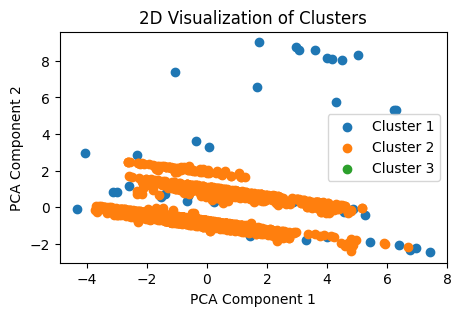

In [18]:
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(scaled_data)

# Plot the data points with cluster labels
plt.figure(figsize=(5, 3))
for i in range(cluster_no):
    plt.scatter(data_2d[clusters == i, 0], data_2d[clusters == i, 1], label=f'Cluster {i+1}')
plt.title('2D Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

Average Silhouette Score: 0.5923628014178498


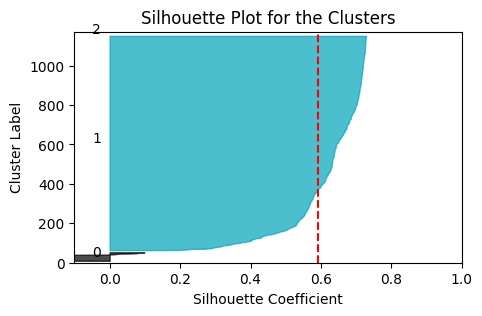

<Figure size 400x300 with 0 Axes>

In [19]:
# Number of clusters for KMeans
n_clusters = cluster_no
# Add cluster labels to the original DataFrame
df['Cluster'] = clusters
# Count the number of data points in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f"Average Silhouette Score: {silhouette_avg}")

# Calculate the Silhouette Coefficients for each sample
sample_silhouette_values = silhouette_samples(scaled_data, clusters)

# Create the Silhouette Plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(5, 3)

# Set limits for the plot
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(scaled_data) + (n_clusters + 1) * 10])

# Initialize the y-axis position
y_lower = 10

for i in range(n_clusters):
    # Aggregate silhouette scores for samples in cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

# Plot the average silhouette score as a vertical line
plt.figure(figsize=(4, 3))
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title("Silhouette Plot for the Clusters")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster Label")
plt.show()

In [ ]:
# joblib.dump(clusters, 'clusters_blade_gaussian.joblib')
# joblib.dump(gmm, 'model_blade_gaussian.joblib')
# joblib.dump(scaler, 'scaler_blade_gaussian.joblib')
# joblib.dump(nearest_neighbors, 'model2_blade_gaussian.joblib')
